In [ ]:
!pip install flair
!pip install pyvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 41.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.5/776.5 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 116.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 8.4 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993221 sha256=621ec5db3aa43821126e36f7af3594578aded1305a645659b14ca9746d94458f
  Stored in directory: /root/.cac

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/01-Research/Geo-Isa/code/")

In [ ]:
!mkdir -p /root/.flair/models/
!cp -R /content/drive/MyDrive/01-Research/Geo-Isa/\code/ner-english-ontonotes-fast /root/.flair/models/

In [ ]:
import pandas as pd
from collections import defaultdict
import Relex
from Relex import CoNetwork, DepNetwork, ConstNetwork
from Relex import FlairNER, SpacyNER
from Relex import spacy_flair_intersection, spacy_flair_union, tagged_tokens_2_rels

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.30G [00:00<?, ?B/s]

2024-09-12 10:49:41,709 SequenceTagger predicts: Dictionary with 75 tags: O, S-PERSON, B-PERSON, E-PERSON, I-PERSON, S-GPE, B-GPE, E-GPE, I-GPE, S-ORG, B-ORG, E-ORG, I-ORG, S-DATE, B-DATE, E-DATE, I-DATE, S-CARDINAL, B-CARDINAL, E-CARDINAL, I-CARDINAL, S-NORP, B-NORP, E-NORP, I-NORP, S-MONEY, B-MONEY, E-MONEY, I-MONEY, S-PERCENT, B-PERCENT, E-PERCENT, I-PERCENT, S-ORDINAL, B-ORDINAL, E-ORDINAL, I-ORDINAL, S-LOC, B-LOC, E-LOC, I-LOC, S-TIME, B-TIME, E-TIME, I-TIME, S-WORK_OF_ART, B-WORK_OF_ART, E-WORK_OF_ART, I-WORK_OF_ART, S-FAC


In [ ]:
NEGATIVE_FLAG = "no_relation"
rel_headers = ["sent_idx", "sent_text", "rel_type", "ent1_text", "ent2_text", "ent1_type", "ent2_type", "ent1_id", "ent2_id", "in_between_text", "sdp_dist", "sdp_path", "sdp_dep_pos", "const_pos"]

# Prepare features and rules

In [ ]:
def rule_0(gt):
    if gt=="no_relation":
        return 0
    else:
        return 1

# Sitreps

In [ ]:
def rule_1(dep):
    if len(dep)>=2 and len(dep)<=16:
        if len(set(dep))==1 and dep[0]=="PROPN":
            return 1
    return 0

def rule_2(dep):
    ptn = ["VERB", "ADP", "PROPN"]
    if " ".join(ptn) in " ".join(dep):
        return 1
    return 0

def rule_3(dep):
    ptn = ["VERB", "NOUN"]
    if " ".join(ptn) in " ".join(dep):
        return 1
    return 0

# def rule_3(dep):
#     ptn = ["VERB", "NOUN"]
#     if " ".join(ptn) in " ".join(dep):
#         return 1
#     return 0

def rule_4(const):
    if len(const)>=1 and len(const)<=8:
        if len(set(const))==1 and const[0]=="PROPN":
            return 1
    return 0

def rule_5(const):
    # if "CCONJ" == const[0]:
    if "CCONJ" in const:
        return 1
    return 0

def rule_6(const):
    if "ADP" in const:
        return 1
    return 0

def rule_7(co_dist):
    if co_dist in [1, 2, 3, 4, 5]: # increased to top 5
        return 1
    return 0

def rule_8(dep_dist):
    if dep_dist in [1, 3, 4, 5, 6]:
        return 1
    return 0

In [ ]:
# for gt data
sitreps_tagged_tokens_path = "~/sitreps_tagged_tokens.csv"
sitreps_gt_relations_path = "~/sitreps_gt_relations_0417.csv"

sitreps_tagged_tokens = pd.read_csv(sitreps_tagged_tokens_path, keep_default_na=False, dtype={'human_annotation_ent_id': str}).values.tolist()
sitreps_gt_relations = pd.read_csv(sitreps_gt_relations_path, keep_default_na=False).values.tolist()

potential_rels = tagged_tokens_2_rels(sitreps_tagged_tokens)
gt_tf_table = defaultdict(lambda: {})
for gt_rel in sitreps_gt_relations:
    gt_tf_table[gt_rel[0]][frozenset([gt_rel[7], gt_rel[8]])] = gt_rel[2]

for rel in potential_rels:
    if frozenset([rel[7], rel[8]]) in gt_tf_table[rel[0]].keys():
        gt_rel_type = gt_tf_table[rel[0]][frozenset([rel[7], rel[8]])]
    else:
        gt_rel_type = "no_relation"

    rel[2] = gt_rel_type

sitreps_gt_relations = potential_rels

In [ ]:
sitreps_gt_relations[19]

[5,
 'EMERGENCY OPERATIONS \n',
 'no_relation',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'no_path_found',
 'no_path_found',
 'no_path_found',
 '']

In [ ]:
sitreps_tagged_tokens[:4]

[['Hurricane', 'PROPN', 'compound', 1, 0, 9, 0, 0, '0', 'LOC'],
 ['Matthew', 'PROPN', 'nsubj', 2, 10, 17, 1, 0, '0', 'LOC'],
 ['was', 'AUX', 'ROOT', 2, 18, 21, 2, 0, '', ''],
 ['a', 'DET', 'det', 5, 22, 23, 3, 0, '', '']]

In [ ]:
def sitreps_features(gt_relations):
    features = []
    for gt_rel in gt_relations:
        co_dist = len(gt_rel[9].split(" "))
        dep_dist = gt_rel[10]
        dep = gt_rel[12]
        const = gt_rel[13]
        features.append([
            rule_0(gt_rel[2]), rule_1(dep), rule_2(dep), rule_3(dep), rule_4(const), rule_5(const), rule_6(const), rule_7(co_dist), rule_8(dep_dist)
            #rule_0(gt_rel[2]), rule_1(dep), rule_2(dep), rule_3(dep), rule_4(const), rule_5(const), rule_6(const), rule_7(co_dist), rule_8(dep_dist)
        ])
    return features

In [ ]:
sitreps_gt_features = sitreps_features(sitreps_gt_relations)

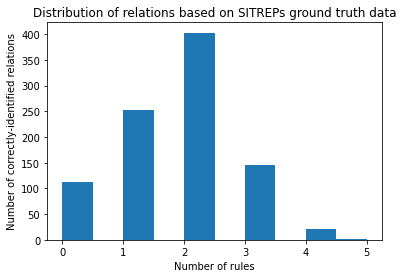

In [ ]:
sitreps_positive_dist = [sum(row[1:]) for row in sitreps_gt_features if row[0]==1]
sitreps_negative_dist = [sum(row[1:]) for row in sitreps_gt_features if row[0]==0]
import matplotlib.pyplot as plt
plt.hist(sitreps_positive_dist)
plt.xlabel('Number of rules')
plt.ylabel('Number of correctly-identified relations')
plt.title('Distribution of relations based on SITREPs ground truth data')
#plt.show()
plt.savefig("sitreps_positive_dist.pdf")

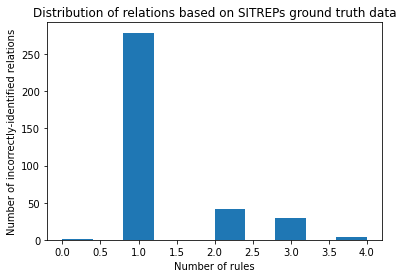

In [ ]:
plt.hist(sitreps_negative_dist)
plt.xlabel('Number of rules')
plt.ylabel('Number of incorrectly-identified relations')
plt.title('Distribution of relations based on SITREPs ground truth data')
#plt.show()
plt.savefig("sitreps_negative_dist.pdf")

In [ ]:
#gt_features_df = pd.DataFrame(gt_features, columns=["gt", "dep1", "dep2", "dep3", "const1", "const2", "const3", "co_dist", "dep_dist"])
sitreps_gt_features_df = pd.DataFrame(sitreps_gt_features, columns=["gt", "dep1", "dep2", "dep3", "const1", "const2", "const3", "co_dist", "dep_dist"])

In [ ]:
sitreps_gt_features_df.to_csv('gt_features.csv')

In [ ]:
from sklearn.model_selection import train_test_split
X = sitreps_gt_features_df.drop(["gt"], axis=1)
y = sitreps_gt_features_df["gt"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train.shape, X_test.shape

((1033, 8), (259, 8))

In [ ]:
# import SVC classifier
from sklearn.svm import SVC
# import metrics to compute accuracy
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
# instantiate classifier with default hyperparameters
sitreps_svc=SVC()

# fit classifier to training set
sitreps_svc.fit(X_train,y_train)

# make predictions on test set
y_pred=sitreps_svc.predict(X_test)

print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
print('Model Precision score with default hyperparameters: {0:0.4f}'. format(precision_score(y_test, y_pred)))
print('Model Recall score with default hyperparameters: {0:0.4f}'. format(recall_score(y_test, y_pred)))


Model accuracy score with default hyperparameters: 0.8340
Model Precision score with default hyperparameters: 0.8626
Model Recall score with default hyperparameters: 0.8971


In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np
scores = cross_val_score(sitreps_svc, X, y, cv=10)
scores

array([0.86923077, 0.91538462, 0.89922481, 0.94573643, 0.8372093 ,
       0.92248062, 0.84496124, 0.84496124, 0.76744186, 0.69767442])

In [ ]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.85 accuracy with a standard deviation of 0.07


In [ ]:
recall = cross_val_score(sitreps_svc, X_train, y_train, cv=10, scoring='recall')
print('Recall', np.mean(recall), recall)
precision = cross_val_score(sitreps_svc, X_train, y_train, cv=10, scoring='precision')
print('Precision', np.mean(precision), precision)
f1 = cross_val_score(sitreps_svc, X_train, y_train, cv=10, scoring='f1')
print('F1', np.mean(f1), f1)

Recall 0.9017088174982911 [0.94805195 0.88311688 0.87012987 0.86842105 0.90789474 0.92105263
 0.90789474 0.90789474 0.92105263 0.88157895]
Precision 0.929131485129937 [0.96052632 0.94444444 0.98529412 0.91666667 0.90789474 0.90909091
 0.90789474 0.90789474 0.92105263 0.93055556]
F1 0.9148204794041025 [0.95424837 0.91275168 0.92413793 0.89189189 0.90789474 0.91503268
 0.90789474 0.90789474 0.92105263 0.90540541]


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.70      0.73        84
           1       0.86      0.90      0.88       175

    accuracy                           0.83       259
   macro avg       0.81      0.80      0.81       259
weighted avg       0.83      0.83      0.83       259



In [ ]:
## Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 100)
clf.fit(X_train, y_train)
y_pred_rf = clf.predict(X_test)

In [ ]:
recall = cross_val_score(clf, X_train, y_train, cv=10, scoring='recall')
print('Recall', np.mean(recall), recall)
precision = cross_val_score(clf, X_train, y_train, cv=10, scoring='precision')
print('Precision', np.mean(precision), precision)
f1 = cross_val_score(clf, X_train, y_train, cv=10, scoring='f1')
print('F1', np.mean(f1), f1)

Recall 0.8990772385509228 [0.94805195 0.88311688 0.87012987 0.86842105 0.90789474 0.92105263
 0.90789474 0.90789474 0.90789474 0.86842105]
Precision 0.92892841289536 [0.96052632 0.94444444 0.98529412 0.91666667 0.90789474 0.90909091
 0.90789474 0.90789474 0.92       0.92957746]
F1 0.9133613225498355 [0.95424837 0.91275168 0.92413793 0.89189189 0.90789474 0.91503268
 0.90789474 0.90789474 0.91390728 0.89795918]


# Tweets

In [ ]:
def rule_9(dep):
    if len(dep)>=2 and len(dep)<=4:
        if len(set(dep))==1 and dep[0]=="PROPN":
            return 1
    return 0

# def rule_10(dep):
#     if "VERB" in dep:
#         return 1
#     return 0

def rule_10(dep):
    ptn = ["VERB", "ADP"]
    if ptn[0] in dep or ptn[1] in dep or " ".join(ptn) in " ".join(dep):
        return 1
    return 0

def rule_11(dep):
    if "NOUN" in dep:
        return 1
    return 0

# def rule_11(dep):
#     ptn = ["NOUN","ADP"]
#     if " ".join(ptn) in " ".join(dep):
#         return 1
#     return 0

def rule_12(const):
    if len(const)>=1 and len(const)<=3:
        if len(set(const))==1 and const[0]=="PROPN":
            return 1
    return 0

def rule_13(const):
    ptn = ["VERB", "ADP"]
    if ptn[0] in const or ptn[1] in const or " ".join(ptn) in " ".join(const):
        return 1
    return 0

def rule_14(const):
    ptn = ["NOUN", "ADP"]
    if " ".join(ptn) in " ".join(const):
        return 1
    return 0

def rule_15(co_dist):
    if co_dist in [1, 3, 4, 2, 0]:
        return 1
    return 0

def rule_16(dep_dist):
    if dep_dist in [3, 4, 5, 2, 6]:
        return 1
    return 0

In [ ]:
# for gt data
tweets_tagged_tokens_path = "/content/drive/MyDrive/01-Research/Geo-Isa/code/Relex/april_16/tweets_tagged_tokens.csv"
tweets_gt_relations_path = "/content/drive/MyDrive/01-Research/Geo-Isa/code/Relex/april_16/tweets_gt_relations.csv"
tweets_tagged_tokens = pd.read_csv(tweets_tagged_tokens_path, keep_default_na=False, dtype={'human_annotation_ent_id': str}).values.tolist()
tweets_gt_relations = pd.read_csv(tweets_gt_relations_path, keep_default_na=False).values.tolist()

tweets_potential_rels = tagged_tokens_2_rels(tweets_tagged_tokens)

gt_tf_table = defaultdict(lambda: {})
for gt_rel in tweets_gt_relations:
    gt_tf_table[gt_rel[0]][frozenset([gt_rel[7], gt_rel[8]])] = gt_rel[2]

for rel in tweets_potential_rels:
    if frozenset([rel[7], rel[8]]) in gt_tf_table[rel[0]].keys():
        gt_rel_type = gt_tf_table[rel[0]][frozenset([rel[7], rel[8]])]
    else:
        gt_rel_type = "no_relation"

    rel[2] = gt_rel_type

tweets_gt_relations = tweets_potential_rels


In [ ]:
tweets_gt_relations[0]

[0,
 'Hurricane Matthew : Weather service issues dire warning https://t.co/i1TP8NjpK9 https://t.co/HmULChCqsC',
 'no_relation',
 'Hurricane Matthew',
 'Weather service',
 'LOC',
 'ORG',
 '0.0',
 '1.0',
 ':',
 'no_path_found',
 'no_path_found',
 'no_path_found',
 ['PUNCT']]

(array([  1.,  85.,   0.,  35.,   0., 131., 228.,   0., 161.,  43.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

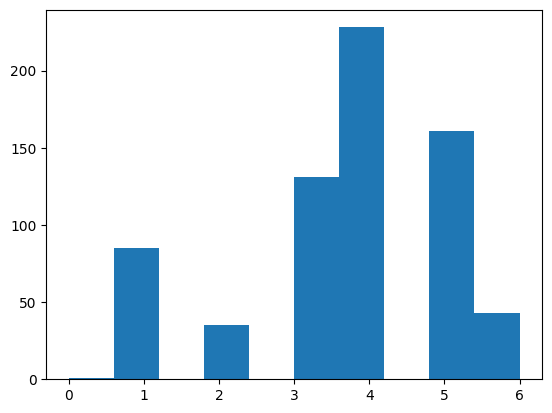

In [ ]:
def tweets_features(tweets_gt_relations):
    tweets_gt_features = []
    for gt_rel in tweets_gt_relations:
        co_dist = len(gt_rel[9].split(" "))
        dep_dist = gt_rel[10]
        dep = gt_rel[12]
        const = gt_rel[13]
        tweets_gt_features.append([
            rule_0(gt_rel[2]), rule_9(dep), rule_10(dep), rule_11(dep), rule_12(const), rule_13(const), rule_14(const), rule_15(co_dist), rule_16(dep_dist)
        ])
    return tweets_gt_features
tweets_gt_features = tweets_features(tweets_gt_relations)
tweets_positive_dist = [sum(row[1:]) for row in tweets_gt_features if row[0]==1]
tweets_negative_dist = [sum(row[1:]) for row in tweets_gt_features if row[0]==0]
import matplotlib.pyplot as plt
plt.hist(tweets_positive_dist)

(array([ 21., 573.,   0., 121.,   0.,  63.,  66.,   0.,  35.,   4.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

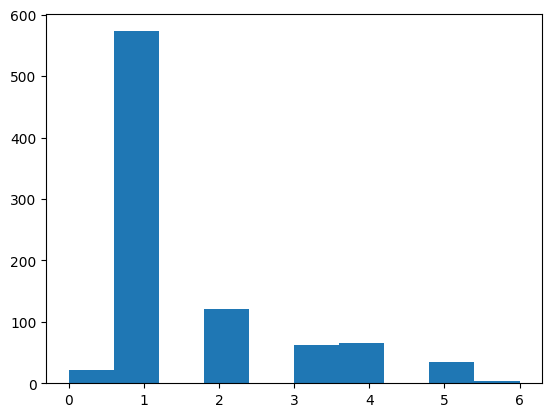

In [ ]:
plt.hist(tweets_negative_dist)

In [ ]:
tweets_gt_features_df = pd.DataFrame(tweets_gt_features, columns=["gt", "dep1", "dep2", "dep3", "const1", "const2", "const3", "co_dist", "dep_dist"])

In [ ]:
from sklearn.model_selection import train_test_split
X = tweets_gt_features_df.drop(["gt"], axis=1)
y = tweets_gt_features_df["gt"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train.shape, X_test.shape

((1253, 8), (314, 8))

In [ ]:
from sklearn.svm import SVC
# import metrics to compute accuracy
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

tweets_svc=SVC()

# fit classifier to training set
tweets_svc.fit(X_train,y_train)

# make predictions on test set
y_pred=tweets_svc.predict(X_test)

# compute and print accuracy score
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
print('Model Precision score with default hyperparameters: {0:0.4f}'. format(precision_score(y_test, y_pred)))
print('Model Recall score with default hyperparameters: {0:0.4f}'. format(recall_score(y_test, y_pred)))


Model accuracy score with default hyperparameters: 0.8057
Model Precision score with default hyperparameters: 0.7736
Model Recall score with default hyperparameters: 0.8311


In [ ]:
# Two models: tweets_svc, sitreps_svc

In [ ]:
recall = cross_val_score(tweets_svc, X_train, y_train, cv=10, scoring='recall')
print('Recall', np.mean(recall), recall)
precision = cross_val_score(tweets_svc, X_train, y_train, cv=10, scoring='precision')
print('Precision', np.mean(precision), precision)
f1 = cross_val_score(tweets_svc, X_train, y_train, cv=10, scoring='f1')
print('F1', np.mean(f1), f1)

NameError: ignored

In [ ]:
## Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 100)
clf.fit(X_train, y_train)
y_pred_rf = clf.predict(X_test)

## Pipeline for automatic entity & relation extraction for raw text data

# ner results

In [ ]:
# from raw text to tagged tokens
# unite or intersect different tagged tokens results
raw_text = "/content/drive/MyDrive/01-Research/Geo-Isa/Coding/evaluation-1600-annotated-tweets.txt"
with open(raw_text) as f:
    data = f.readlines()

In [ ]:
flairner = FlairNER(data)
sents = data
#sents = flairner.sentence_segmentation()

In [ ]:
flair_tts, flair_rels = flairner.generate_tokens_n_rels(sents[:])

100%|██████████| 1672/1672 [00:35<00:00, 46.45it/s]


In [ ]:
sents[12]

'Sevier County Tennessee, picture colored by me.\n'

In [ ]:
spacyner = SpacyNER(data)

In [ ]:
spacy_tts, spacy_rels = spacyner.generate_tokens_n_rels(sents[:])

100%|██████████| 1672/1672 [00:14<00:00, 117.87it/s]


In [ ]:
# experiment different combinations
s_f_i = spacy_flair_intersection(spacy_tts, flair_tts)
#s_f_u = spacy_flair_union(spacy_tts, flair_tts)

In [ ]:
s_f_intersection = pd.DataFrame(s_f_i).to_csv('geoisa_tweets_coded_evaluation_1600_flair_spacy_intersection.csv')
spacy_df = pd.DataFrame(spacy_tts).to_csv('geoisa_tweets_coded_spacy.csv')

# Unseen data analysis

In [ ]:
# from tagged tokens to network
irma_tokens_path = "/content/geoisa_tweets_coded_evaluation_1600_flair_spacy_intersection.csv"
irma_tokens = pd.read_csv(irma_tokens_path, keep_default_na=False, index_col=False).values.tolist()
irma_tokens = [row[1:] for row in irma_tokens]

In [ ]:
irma_tweets_rels = tagged_tokens_2_rels(irma_tokens)
irma_tweets_rels[:10]

[[0,
  'Colorado Springs and most of El Paso County will start the week under a freeze warning Monday , according to the National Weather Service in Pueblo . \n',
  '',
  'Colorado Springs',
  'El Paso County',
  'GPE',
  'GPE',
  '0_0',
  '0_1',
  'and most of',
  2,
  [3, 4],
  ['ADJ', 'ADP'],
  ['CCONJ', 'ADJ', 'ADP']],
 [0,
  'Colorado Springs and most of El Paso County will start the week under a freeze warning Monday , according to the National Weather Service in Pueblo . \n',
  '',
  'Colorado Springs',
  'the National Weather Service',
  'GPE',
  'ORG',
  '0_0',
  '0_4',
  'and most of El Paso County will start the week under a freeze warning Monday , according to',
  3,
  [9, 18, 19],
  ['VERB', 'VERB', 'ADP'],
  ['CCONJ',
   'ADJ',
   'ADP',
   'PROPN',
   'PROPN',
   'PROPN',
   'AUX',
   'VERB',
   'DET',
   'NOUN',
   'ADP',
   'DET',
   'NOUN',
   'NOUN',
   'PROPN',
   'PUNCT',
   'VERB',
   'ADP']],
 [0,
  'Colorado Springs and most of El Paso County will start the week